In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from itertools import product
from tqdm import tqdm_notebook

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [26]:
# import dataset as pandas.DataFrame
data = pd.read_csv('a.tsv', sep='\t', header=0, names=['Person', 'Date', 'Input', 'Result'])

In [27]:
# აბრუნებს data[row[col]-ის მნიშვნელობას. jsn=True იმ შემთხვევაში თუ სვეტის ელემენტი json ფორმატში არის შენახული
# და ჭირდება დესერილიზაცია

def get_value(data, row, col, jsn):
    if jsn:
        return json.loads(data.iloc[row, col])
    else:
        return data.iloc[row, col]
    
def get_size(data, person):
    return data.loc[data.Person == person, ['Person']].shape[0]

In [28]:
persons = data['Person'].unique()
dt = data.copy()
mp = {}
for person in persons:
    mp[person] = get_size(data, person)
rs = []
for i in data.index:
    rs.append(mp[get_value(data, i, 0, False)])
dt['cnt'] = rs
dt = dt.loc[dt.cnt >= 50, :]
data = dt
data.head()

,Person,Date,Input,Result,cnt
0,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",173
1,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",173
2,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",173
3,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",173
4,1,2014-09-19,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2158}...",173


In [29]:
def calories_goal_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['goal'][i]['name'] == 'Calories':
            return result['goal'][i]['value']
    return -1

In [30]:
def calories_total_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Calories':
            return result['total'][i]['value']
    return -1

In [31]:
def get_difference(data, row):
    result = get_value(data, row, 3, True)
    total_calories = 0
    goal_calories = 0
    total_sugar = 0
    goal_sugar = 0
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Sugar':
            total_sugar = result['total'][i]['value']
        if result['total'][i]['name'] == 'Calories':
            total_calories = result['total'][i]['value']
        if result['goal'][i]['name'] == 'Calories':
            goal_calories = result['goal'][i]['value']
        if result['goal'][i]['name'] == 'Sugar':
            goal_sugar = result['goal'][i]['value']
    return abs(goal_calories - total_calories), abs(goal_sugar - total_sugar)

In [32]:
def get_date_index(dates, date):
    for i in range(len(dates)):
        if dates[i] == date:
            return i
    return -1

In [33]:
def dates_contains_date(dates, date):
    for cur_date in dates:
        if cur_date == date:
            return True
    return False

In [34]:
remaining_persons = data['Person'].to_numpy()
person_id = remaining_persons[5];
person_dt = data.loc[data.Person == person_id, :].copy()
person_dates = person_dt['Date'].to_numpy()
dates = data['Date'].unique()

In [35]:
new_dates = []
for date in dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_dates.append(x)
dates = new_dates
dates.sort()
new_person_dates = []
for date in person_dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_person_dates.append(x)
person_dates = new_person_dates
person_dates.sort()

In [36]:
# print(dates)
# print(person_dates)
beta = 0.9
lst = []
lst2 = []
for i in person_dt.index:
    lst.append(get_difference(data, i)[0])
    lst2.append(get_difference(data, i)[1])
mx = max(lst)
mx2 = max(lst2)
if mx == 0:
    mx = 1
if mx2 == 0:
    mx2 = 1
for i in range(len(lst)):
    lst[i] /= mx 
    lst[i] = lst[i] * 0.7 * 100
    lst2[i] /= mx2 
    lst2[i] = lst2[i] * 0.3 * 100
    
results = []
lsts_index = 0
frm = get_date_index(dates, person_dates[0])
to = get_date_index(dates, person_dates[len(person_dates) - 1])
missed_days = 0
for i in range(frm, to+1):
    date = dates[i]
    if not dates_contains_date(person_dates, date):
        missed_days += 1
        results.append(results[len(results) - 1] * beta)
    else:
        if len(results) == 0:
            results.append((1 - beta) * (100 - lst[lsts_index] - lst2[lsts_index]))
        else:
            results.append(results[len(results) - 1] * beta + (1 - beta) * (100 - lst[lsts_index] - lst2[lsts_index]))
        lsts_index += 1

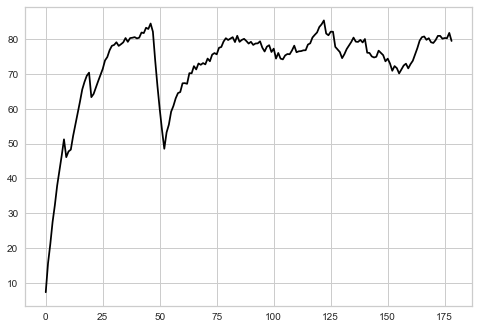

In [37]:
plt.plot(results, color='black')
plt.show()

In [38]:
person_dt = pd.DataFrame({"Function" : results})

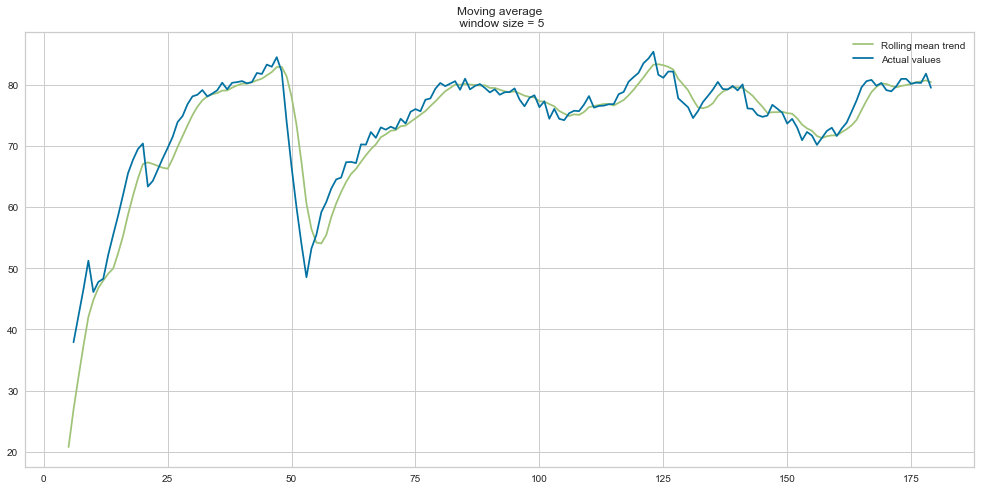

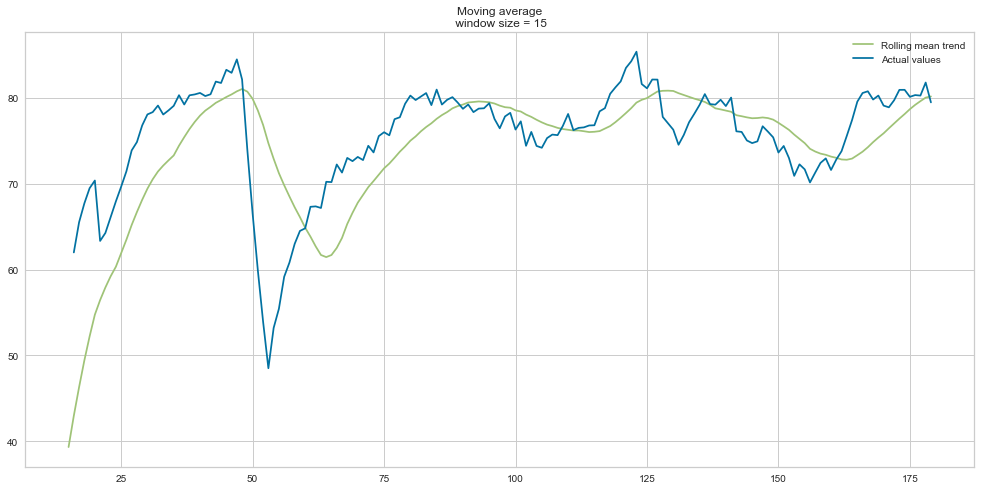

In [39]:
def plot_moving_average(series, window, length, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    arr = [i for i in range(1, length + 1)]
    plt.plot(arr, rolling_mean, 'g', label='Rolling mean trend')
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(arr,upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(arr, lower_bound, 'r--')          
    plt.plot(arr[window:], series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(person_dt.Function, 5, len(results))
#Smooth by the previous month (30 days)
plot_moving_average(person_dt.Function, 15, len(results))

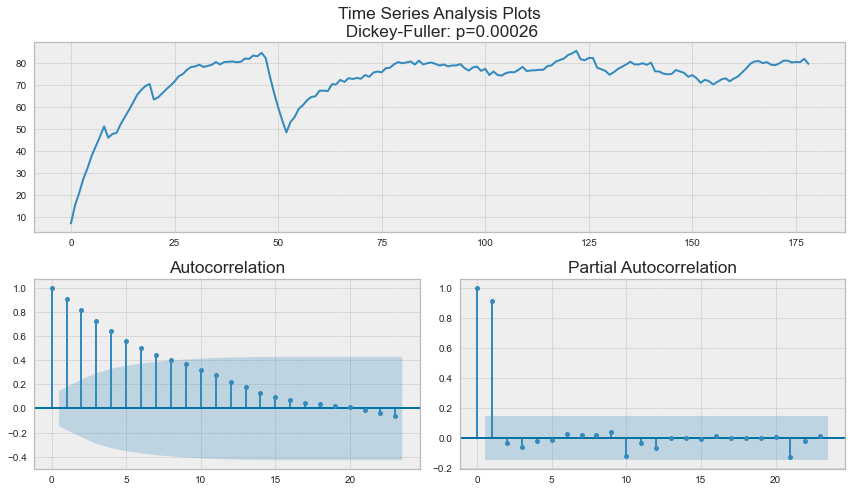

In [40]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    return p_value 
        
p_value = tsplot(person_dt.Function, lags=None)

if p_value > 0.1:  
    # function()
    data_diff = person_dt.Function - person_dt.Function.shift(1)
    tsplot(data_diff[10:], lags=30)

In [41]:
from statsmodels.tsa.arima.model import ARIMA
ps = range(0, 5)
qs = range(0, 5)
d = 1
parameters = product(ps, qs)

In [42]:
def optimize_ARIMA(parameters_list, d):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(person_dt.Function, order=(param[0], d, param[1])).fit()
        aic = model.aic
    
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    results = sorted(results, key=lambda x: x[1])
    
    return results[0][0]

In [43]:
p, q = optimize_ARIMA(list(parameters), d)

best_model = ARIMA(person_dt.Function, order=(p, d, q)).fit()

print(best_model.summary())

<ipython-input-42-a77b3cc36e53>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



                               SARIMAX Results                                
Dep. Variable:               Function   No. Observations:                  179
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -370.505
Date:                Fri, 19 Feb 2021   AIC                            747.010
Time:                        21:00:36   BIC                            756.556
Sample:                             0   HQIC                           750.881
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3544      0.057      6.171      0.000       0.242       0.467
ar.L2          0.3011      0.067      4.501      0.000       0.170       0.432
sigma2         3.7523      0.235     15.959      0.

C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
def plot_ARIMA(series, model, n_steps):
    data = series.copy().rename(columns = {'Function': 'actual'})
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

s = 15

values = (best_model.predict(start=person_dt.Function.shape[0], end=person_dt.Function.shape[0] + s)).to_list()
print(mean_absolute_percentage_error(person_dt.Function[s+d:], best_model.fittedvalues[s+d:]))

1.7025990549207066


In [45]:
comparison = pd.DataFrame({'actual': person_dt.Function[-s - 1:],
                          'predicted': values})

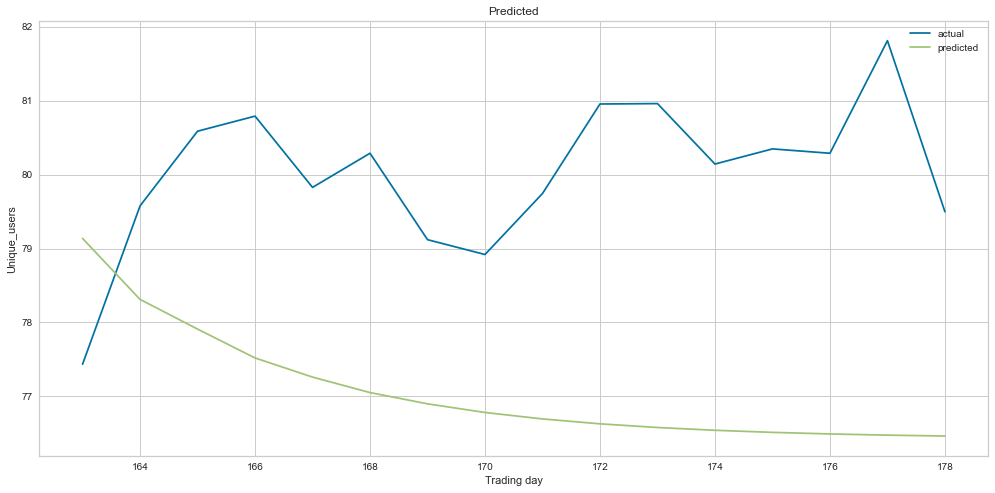

In [46]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual, label='actual')
plt.plot(comparison.predicted, label='predicted')
plt.title('Predicted')
plt.ylabel('Unique_users')
plt.xlabel('Trading day')
plt.legend()
plt.show()

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

ModuleNotFoundError: No module named 'keras'

In [ ]:
def lstm_split_sequence(sequence,n_steps_in,n_steps_out=1):
    X,y = list(),list()  
    for i in range(len(sequence)-n_steps_in):
        end_ix = i+n_steps_in # ამ ვინდოუს ბოლო ინდექსი
        out_end_ix = end_ix+n_steps_out #ვინდოუს დამატებული დასაფრედიქთებელის ბოლო ინდექსი
        if len(sequence)-n_steps_out < end_ix:
            break
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [272]:
train_test_split_ratio = 0.8
def train_test_split(value,n_steps_in,n_steps_out=1):
    X,y = lstm_split_sequence(value,n_steps_in,n_steps_out)  
    split_index = round(len(X)*train_test_split_ratio)
    
    X_train,X_test = X[:split_index],X[split_index:]
    y_train,y_test = y[:split_index],y[split_index:]
    
    return X_train,X_test,y_train,y_test

In [273]:
n_features = 1
n_steps_in = 7 #ავიღოთ 7 დღიანი ვინდოუები
n_steps_out = 1
ts = person_dt.Function.values
X_train,X_test,y_train,y_test = train_test_split(ts,n_steps_in,n_steps_out)
test_len = y_test.shape[0]
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [294]:
vanilla_gru_model = Sequential()
vanilla_gru_model.add(GRU(30,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
vanilla_gru_model.add(Dense(1))
vanilla_gru_model.compile(optimizer = 'adam',loss='mse')
vanilla_gru_model.summary()
vanilla_gru_model.fit(X_train,y_train,epochs = 50,verbose=0)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 30)                3510      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 3,541
Trainable params: 3,541
Non-trainable params: 0
_________________________________________________________________


2/2 - 0s


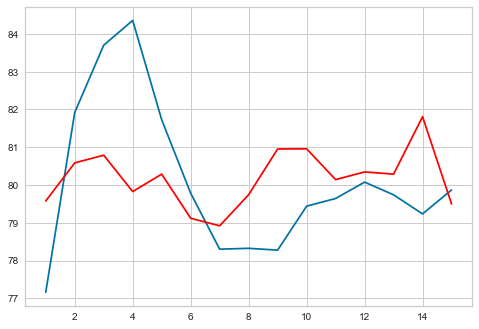

In [297]:
vanilla_gru_prediction = vanilla_gru_model.predict(X_test,verbose=2)
plt.plot([i for i in range(1, s+1)], vanilla_gru_prediction[-s:])
plt.plot([i for i in range(1, s+1)], y_test[-s:], color='red')